# Semi-supervised learning - CAM
Class Activation Map, CNN visualization를 구현합니다.

이번 예제에서는 고양이와 개를 분류하는 분류기를 이용합니다.
예측 결과와 함께 CNN 분류기가 '어느 위치'를 보고 추론 했는지 시각화 하는 것이 주요 학습 포인트 입니다.

In [1]:
import cv2
import numpy as np
import os
from glob import glob
import sys

import tensorflow as tf
from keras import backend as K
import keras
from keras.models import model_from_json
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)

Using TensorFlow backend.


In [2]:
with open(os.path.join('./models/vgg_like/model.json'), 'r') as json_file:
            loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
model.load_weights('./models/vgg_like/weights.05.h5')
print ('[*] model loaded!')
        
model.summary()

[*] model loaded!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0  

In [3]:
list_image_names = []
for (path, dir, files) in os.walk("./data/cats_vs_dogs"):
    for filename in files:
        img_path = "%s/%s" % (path, filename)
        ext = os.path.splitext(filename)[-1]
        if ext == '.png':
#             print("%s" % (img_path))
            list_image_names.append(img_path)
print (sorted(list_image_names))

['./data/cats_vs_dogs/cat/1.png', './data/cats_vs_dogs/cat/2.png', './data/cats_vs_dogs/cat/3.png', './data/cats_vs_dogs/cat/4.png', './data/cats_vs_dogs/cat/5.png', './data/cats_vs_dogs/dog/10.png', './data/cats_vs_dogs/dog/6.png', './data/cats_vs_dogs/dog/7.png', './data/cats_vs_dogs/dog/8.png', './data/cats_vs_dogs/dog/9.png']


In [4]:
def image_read(path, color_mode=1, target_size=128):
    img = cv2.imread(path, color_mode)
    img = cv2.resize(img, (target_size, target_size))
    show = img
    img = img.astype(np.float32)
    img = 2*(img - 128)/255
    return [img, show]

In [5]:
data_list = []
[data_list.append(image_read(path, color_mode=1, target_size=128)) for path in list_image_names]
print (len(data_list))

10


In [6]:
np_input_data_list = np.array(data_list)[:,0,:,:,:]
np_original_data_list = np.array(data_list)[:,1,:,:,:].astype(np.uint8)

In [7]:
result = model.predict(np_input_data_list, batch_size=10)

In [8]:
prediction_labels = np.argmax(result, axis=1)
print (prediction_labels)

[0 0 0 0 0 0 1 1 1 1]


visualization할 함수를 정의합니다.
CAM 구조로 연산을 수행합니다.

    1. activation_11의 결과를 interpolation(resize)
    2. fully connected layer의 weight와 곱
    3. feature summation

순서로 수행합니다.
2, 3 과정은 dot product로 weighted summation 할 수 있습니다.

In [32]:
def get_classmap_keras(model, img, labels):
    inc = model.layers[0].output
    conv6 = model.get_layer('activation_11').output # last relu ?,16,16,1024
    channel = int(conv6.shape[3])
    conv6_resized = tf.image.resize_bilinear(conv6, [int(inc.shape[1]), int(inc.shape[2])]) 
                    # ?,128,128,1024
    weight = model.layers[-1].kernel # 1024, 2
    weight = K.reshape(weight, [-1, channel, 2]) # 1, 1024, 2
    conv6_resized = K.reshape(conv6_resized, 
                    [-1, int(inc.shape[1])*int(inc.shape[2]),  channel]) #128*128 = 16384
                    # ?, 16384, 1024
        
        
    classmap = K.dot(conv6_resized, weight) # ?, 16384, 2
    classmap = K.reshape(classmap, [-1, int(inc.shape[1]), int(inc.shape[2]), 2]) # ?,128,128,1024
    get_cmap = K.function([inc, K.learning_phase()], [classmap])
    [np_classmap] = get_cmap([img, 0])
    
    np_classmap[np.where(np_classmap < 0.0)] = 0    
    np_classmap = map(lambda x:((x-x.min())/(x.max()-x.min())),np_classmap)    # normalize to between 0~1
    np_classmap = np.array(list(np_classmap))

    return (np_classmap*255).astype(np.uint8)

In [33]:
classmap = get_classmap_keras(model, np_input_data_list, prediction_labels)

In [34]:
assert classmap.shape[0] == np_original_data_list.shape[0] == prediction_labels.shape[0]

[*] 1's label : cat


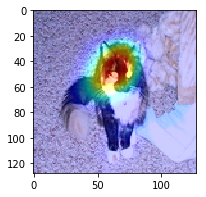

[*] 2's label : cat


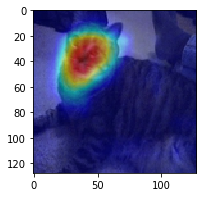

[*] 3's label : cat


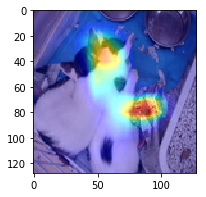

[*] 4's label : cat


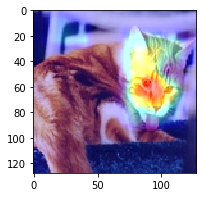

[*] 5's label : cat


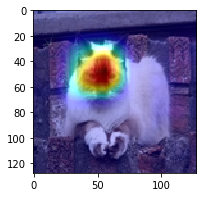

[*] 6's label : cat


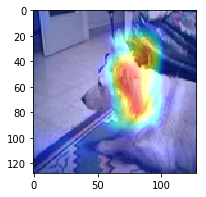

[*] 7's label : dog


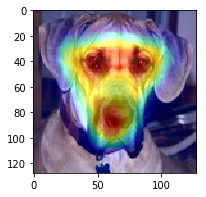

[*] 8's label : dog


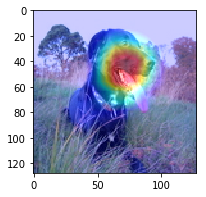

[*] 9's label : dog


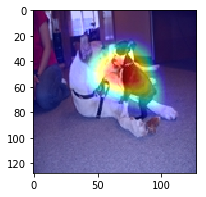

[*] 10's label : dog


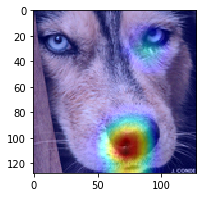

[*] done


In [35]:
label_list = ['cat', 'dog']
for idx in range(classmap.shape[0]):
    predicted_label = prediction_labels[idx]
    print ("[*] %d's label : %s"%(idx+1, label_list[predicted_label]))
    img_original = np_original_data_list[idx,:,:,:]
    img_classmap = classmap[idx,:,:,predicted_label]
    color_classmap = cv2.applyColorMap(img_classmap, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_original, 0.8, color_classmap, 0.5, 0.)

    cv2.imwrite("./result/%s_%d.png"%(label_list[predicted_label],idx+1), img_show)
    
    plt.figure(figsize=(3,3))
    rgb_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_show)
    plt.show()

print ("[*] done")